<a href="https://colab.research.google.com/github/Felix-Obite/Active-Inference-World-Models-for-Continual-Multimodal-Intelligence/blob/main/Embodied_Agents_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
CURL: Transformer World Model + Symbolic Trajectory Learning

Loading text encoder...
Text encoder loaded!

Environment: MiniGrid-Empty-8x8-v0
Image shape: (3, 7, 7)
Mission: 'Navigate to the goal location. You are facing right.'
Action space: 7

CURL: COMPLETE PIPELINE
Transformer World Model + Symbolic Trajectory Learning

PHASE 1: Collecting Offline Data
  Collected 30/150 episodes
  Collected 60/150 episodes
  Collected 90/150 episodes
  Collected 120/150 episodes
  Collected 150/150 episodes
✓ Total episodes: 150

PHASE 2: Training Semantic Tokenizer (Offline)
  Epoch 200/800 | Loss: 1.3554 | Img: 1.3550 | Txt: 0.0008
  Epoch 400/800 | Loss: 0.7950 | Img: 0.7947 | Txt: 0.0006
  Epoch 600/800 | Loss: 0.4841 | Img: 0.4838 | Txt: 0.0008
  Epoch 800/800 | Loss: 0.2825 | Img: 0.2820 | Txt: 0.0010
✓ Semantic tokenizer trained!

PHASE 3: Training Transformer World Model (Offline)
  Epoch 150/600 | Loss: 0.1689 | Token: 0.1614 | Reward: 0.0066 | Done: 0.0017
  Epoch 300/

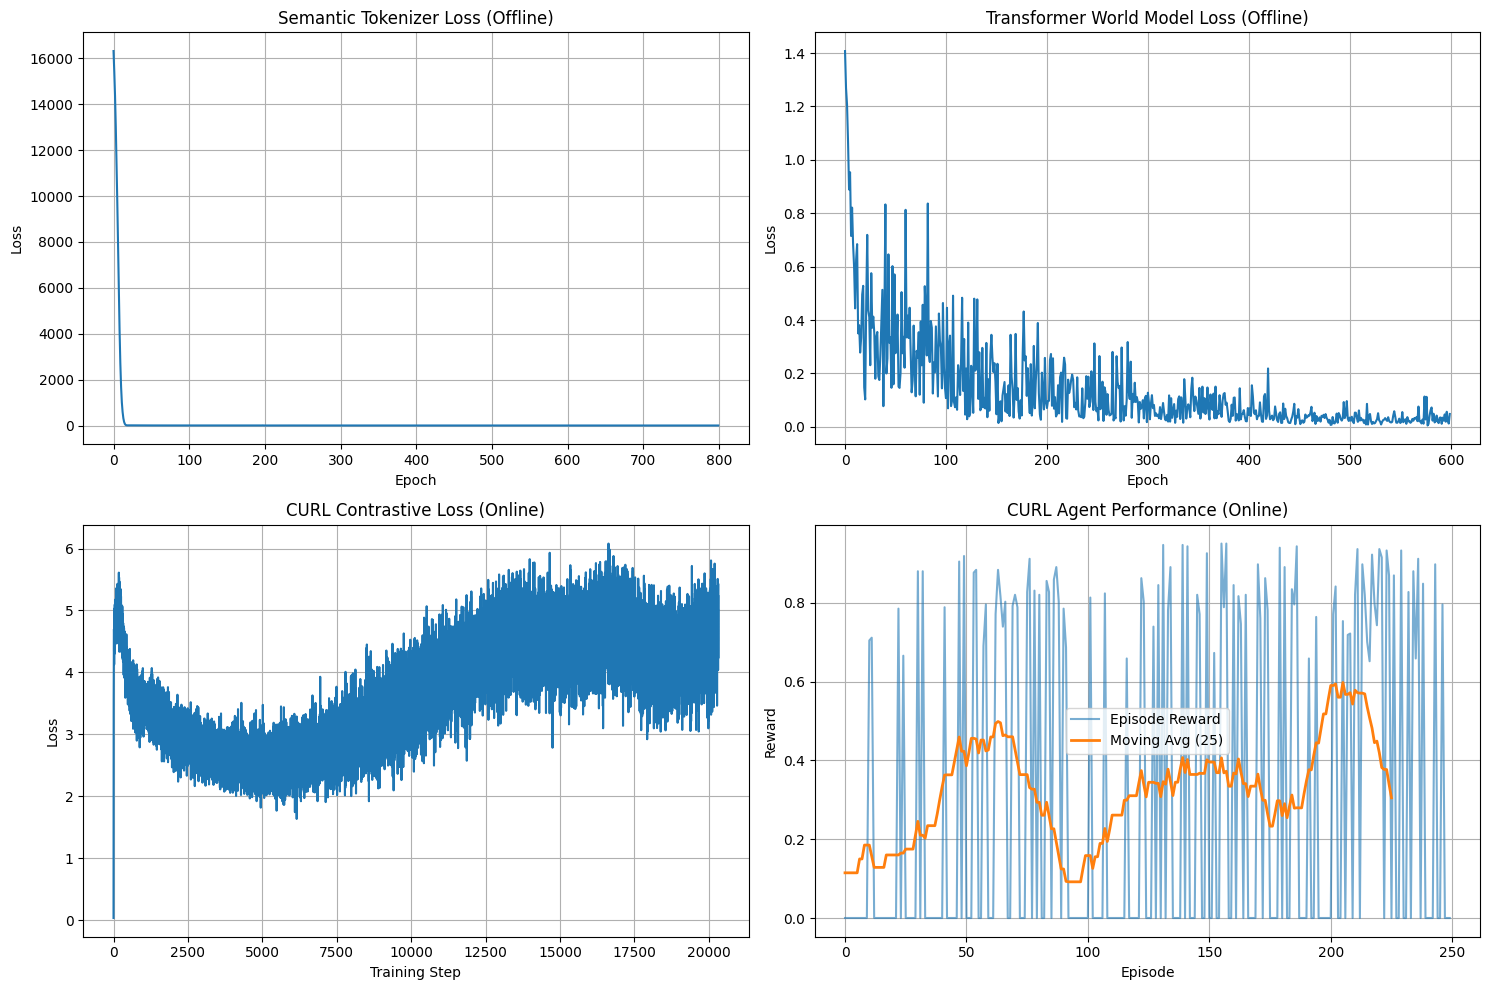


✓ Results saved to curl_full_pipeline.png


In [4]:
# =========================================================
# Researcher: Dr. Felix Obite     05/01/2026

# CURL-WM: Contrastive Unsupervised Representation Learning with Multimodal World Models

# Training Pipeline:
# Data Collection: Random exploration with multimodal observations
# VAE Training: Learn joint vision-language representation
# World Model: Predict multimodal dynamics
# CURL Training: Contrastive learning for robust representations
# Evaluation: Compare against random baseline

# Architecture:
# 1. Offline: Transformer-based world model learns multimodal semantic tokens(images + text)
# 2. Online: CURL fine-tunes on symbolic trajectory representations
#
# Environment: MiniGrid with Vision + Language
# =========================================================
# The multimodal environment is created through a custom wrapper that:
# 1. Maintains the original MiniGrid visual observations
# 2. Generates dynamic, contextual language based on:
#  - Task objectives
#  - Agent state (direction)
#  - Episode progress
# 3. Returns both modalities in synchronized dictionary format
# This enables the transformer world model to learn multimodal semantic representations that ground language in visual perception!

# ====================================================================
# Main Pipeline Architecture
# =====================================================================

# Stage 1: Offline Training - Semantic Token Learning
# - Multimodal Semantic Tokenizer: Compresses raw observations (image + text) into dense semantic tokens (256D)
# - Vision CNN encoder + Language MLP encoder
# - Fusion layer creates unified semantic representation
# - Trained with reconstruction losses (autoencoder objective)

# Stage 2: Offline Training - Transformer World Model
# - Transformer-based World Model: Learns dynamics over semantic token sequences
# - GPT-2 architecture (6 layers, 8 heads)
# - Operates on sequences of semantic tokens + action embeddings
# - Predicts: next semantic tokens, rewards, termination
# - Learns temporal dependencies and world dynamics

# Stage 3: Symbolic Trajectory Encoding
# - rajectory Encoder: Compresses semantic token sequences into fixed-size trajectory representations
# - Bidirectional LSTM over token sequences
# - Creates symbolic trajectory representations (128D)
# - Captures long-term dependencies in behavior

# Stage 4: Online Fine-tuning - CURL
# - CURL Agent: Contrastive learning on symbolic trajectories
# - Momentum contrastive learning with large negative queue (4096 samples)
# - Contrasts temporally close trajectory segments
# - Policy operates on learned trajectory representations
# - Online fine-tuning with epsilon-greedy exploration

# -------------------------------
# INSTALL DEPENDENCIES
# -------------------------------
!pip install gymnasium minigrid torch transformers sentence-transformers matplotlib numpy --quiet

# -------------------------------
# IMPORTS
# -------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from typing import List, Tuple, Dict

import gymnasium as gym
import minigrid
from sentence_transformers import SentenceTransformer
from transformers import GPT2Config, GPT2Model

# -------------------------------
# GLOBAL CONFIG
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

ENV_NAME = "MiniGrid-Empty-8x8-v0"
SEMANTIC_TOKEN_DIM = 256  # Dimension of semantic tokens (compressed multimodal representation)
LATENT_DIM = 128  # Final compressed representation for policy
IMAGE_CHANNELS = 3
IMAGE_SIZE = 7
TEXT_DIM = 384

print(f"Using device: {device}")
print("=" * 70)
print("CURL: Transformer World Model + Symbolic Trajectory Learning")
print("=" * 70)

# =========================================================
# TEXT ENCODER
# =========================================================
print("\nLoading text encoder...")
text_encoder_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
text_encoder_model = text_encoder_model.to(device)

def encode_text(text):
    """Encode text to fixed-size embedding"""
    with torch.no_grad():
        embedding = text_encoder_model.encode(text, convert_to_tensor=True)
        return embedding.to(device)

print("Text encoder loaded!")

# =========================================================
# MULTIMODAL ENVIRONMENT
# =========================================================
class MultimodalMiniGridWrapper(gym.Wrapper):
    """Environment wrapper with rich language descriptions"""

    TASK_TEMPLATES = [
        "Navigate to the goal location",
        "Find and reach the green goal square",
        "Move to the target position",
        "Reach the destination marker",
        "Go to the goal tile",
    ]

    DIRECTION_MAP = {0: "facing right", 1: "facing down", 2: "facing left", 3: "facing up"}

    def __init__(self, env):
        super().__init__(env)
        self.current_task = None
        self.steps_taken = 0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.steps_taken = 0
        self.current_task = random.choice(self.TASK_TEMPLATES)

        # Access the unwrapped environment to get agent_dir
        unwrapped_env = self.env.unwrapped
        direction_text = self.DIRECTION_MAP[unwrapped_env.agent_dir]
        mission = f"{self.current_task}. You are {direction_text}."

        return self._create_obs(obs, mission), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.steps_taken += 1

        # Access the unwrapped environment to get agent_dir
        unwrapped_env = self.env.unwrapped
        direction_text = self.DIRECTION_MAP[unwrapped_env.agent_dir]

        if self.steps_taken < 5:
            context = "Just started."
        elif self.steps_taken < 15:
            context = "Making progress."
        else:
            context = "Keep going."

        mission = f"{self.current_task}. You are {direction_text}. {context}"

        return self._create_obs(obs, mission), reward, terminated, truncated, info

    def _create_obs(self, obs, mission):
        img = obs['image']
        img = np.transpose(img, (2, 0, 1))
        return {'image': img, 'mission': mission}


def make_env():
    env = gym.make(ENV_NAME, render_mode=None)
    return MultimodalMiniGridWrapper(env)

# Test
env = make_env()
obs, _ = env.reset()
ACTION_DIM = env.action_space.n
print(f"\nEnvironment: {ENV_NAME}")
print(f"Image shape: {obs['image'].shape}")
print(f"Mission: '{obs['mission']}'")
print(f"Action space: {ACTION_DIM}")
env.close()

# =========================================================
# PHASE 1: MULTIMODAL SEMANTIC TOKENIZER
# This encodes raw observations into semantic tokens
# =========================================================
class MultimodalSemanticTokenizer(nn.Module):
    """
    Encodes multimodal observations (image + text) into semantic tokens
    These tokens represent compressed world state semantics
    """

    def __init__(self, token_dim=SEMANTIC_TOKEN_DIM):
        super().__init__()

        # Visual encoder (CNN)
        self.visual_encoder = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * IMAGE_SIZE * IMAGE_SIZE, 512),
            nn.ReLU()
        )

        # Language encoder (MLP on sentence embeddings)
        self.language_encoder = nn.Sequential(
            nn.Linear(TEXT_DIM, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        # Multimodal fusion to semantic tokens
        self.fusion = nn.Sequential(
            nn.Linear(512 + 256, 512),
            nn.ReLU(),
            nn.Linear(512, token_dim),
            nn.LayerNorm(token_dim)
        )

        # Decoder for reconstruction (for offline training)
        self.visual_decoder = nn.Sequential(
            nn.Linear(token_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64 * IMAGE_SIZE * IMAGE_SIZE),
            nn.ReLU(),
            nn.Unflatten(1, (64, IMAGE_SIZE, IMAGE_SIZE)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, IMAGE_CHANNELS, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

        self.language_decoder = nn.Sequential(
            nn.Linear(token_dim, 256),
            nn.ReLU(),
            nn.Linear(256, TEXT_DIM)
        )

    def encode(self, image, text_emb):
        """Encode multimodal input to semantic token"""
        img_norm = image.float() / 255.0

        vis_feat = self.visual_encoder(img_norm)
        txt_feat = self.language_encoder(text_emb)

        # Fuse into semantic token
        fused = torch.cat([vis_feat, txt_feat], dim=-1)
        semantic_token = self.fusion(fused)

        return semantic_token

    def decode(self, semantic_token):
        """Decode semantic token back to observations (for training)"""
        recon_img = self.visual_decoder(semantic_token)
        recon_txt = self.language_decoder(semantic_token)
        return recon_img, recon_txt

    def forward(self, image, text_emb):
        """Full forward pass with reconstruction"""
        semantic_token = self.encode(image, text_emb)
        recon_img, recon_txt = self.decode(semantic_token)
        return semantic_token, recon_img, recon_txt


# =========================================================
# PHASE 2: TRANSFORMER WORLD MODEL (OFFLINE TRAINING)
# Models dynamics over sequences of semantic tokens
# =========================================================
class TransformerWorldModel(nn.Module):
    """
    Transformer-based world model that operates on semantic token sequences
    Learns to predict future semantic tokens and rewards
    """

    def __init__(self, token_dim=SEMANTIC_TOKEN_DIM, action_dim=ACTION_DIM):
        super().__init__()

        self.token_dim = token_dim

        # Action embedding
        self.action_embedding = nn.Embedding(action_dim, token_dim)

        # Positional encoding
        self.position_embedding = nn.Embedding(128, token_dim)

        # Input projection: [semantic_token, action] -> transformer input
        self.input_projection = nn.Sequential(
            nn.Linear(token_dim * 2, token_dim),
            nn.LayerNorm(token_dim)
        )

        # Transformer encoder
        config = GPT2Config(
            vocab_size=1,  # Not used (we use embeddings directly)
            n_embd=token_dim,
            n_layer=6,
            n_head=8,
            n_positions=128,
            activation_function='gelu'
        )
        self.transformer = GPT2Model(config)

        # Output heads
        self.next_token_predictor = nn.Sequential(
            nn.Linear(token_dim, 512),
            nn.ReLU(),
            nn.Linear(512, token_dim)
        )

        self.reward_predictor = nn.Sequential(
            nn.Linear(token_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.done_predictor = nn.Sequential(
            nn.Linear(token_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, semantic_tokens, actions):
        """
        semantic_tokens: (batch, seq_len, token_dim)
        actions: (batch, seq_len)
        Returns predicted next tokens, rewards, dones
        """
        batch_size, seq_len = actions.shape

        # Embed actions
        action_embs = self.action_embedding(actions)  # (batch, seq_len, token_dim)

        # Combine semantic tokens with actions
        combined = torch.cat([semantic_tokens, action_embs], dim=-1)  # (batch, seq_len, 2*token_dim)
        inputs = self.input_projection(combined)  # (batch, seq_len, token_dim)

        # Add positional encoding
        positions = torch.arange(seq_len, device=inputs.device).unsqueeze(0).expand(batch_size, -1)
        pos_embs = self.position_embedding(positions)
        inputs = inputs + pos_embs

        # Transformer forward
        transformer_output = self.transformer(inputs_embeds=inputs).last_hidden_state

        # Predictions
        next_tokens = self.next_token_predictor(transformer_output)
        rewards = self.reward_predictor(transformer_output)
        dones = self.done_predictor(transformer_output)

        return next_tokens, rewards, dones


# =========================================================
# PHASE 3: SYMBOLIC TRAJECTORY ENCODER
# Compresses semantic token sequences into trajectory representations
# =========================================================
class SymbolicTrajectoryEncoder(nn.Module):
    """
    Encodes sequences of semantic tokens into fixed-size trajectory representations
    Used for CURL contrastive learning
    """

    def __init__(self, token_dim=SEMANTIC_TOKEN_DIM, latent_dim=LATENT_DIM):
        super().__init__()

        # Bidirectional LSTM for sequence encoding
        self.lstm = nn.LSTM(
            input_size=token_dim,
            hidden_size=latent_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        # Project to final representation
        self.projection = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.LayerNorm(latent_dim)
        )

    def forward(self, semantic_tokens):
        """
        semantic_tokens: (batch, seq_len, token_dim)
        Returns: (batch, latent_dim) trajectory representation
        """
        # LSTM encoding
        lstm_out, (h_n, c_n) = self.lstm(semantic_tokens)

        # Use final hidden state (concatenate forward and backward)
        # h_n shape: (num_layers * 2, batch, hidden_size)
        forward_h = h_n[-2]  # Last layer forward
        backward_h = h_n[-1]  # Last layer backward

        combined = torch.cat([forward_h, backward_h], dim=-1)

        # Project to trajectory representation
        trajectory_repr = self.projection(combined)

        return trajectory_repr


# =========================================================
# PHASE 4: CURL AGENT (ONLINE FINE-TUNING)
# Contrastive learning on symbolic trajectory representations
# =========================================================
class CURLAgent(nn.Module):
    """
    CURL agent that uses contrastive learning on symbolic trajectories
    Fine-tunes online after offline world model training
    """

    def __init__(self, latent_dim=LATENT_DIM, action_dim=ACTION_DIM):
        super().__init__()

        # Query encoder
        self.encoder_q = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LayerNorm(128)
        )

        # Momentum encoder (for contrastive learning)
        self.encoder_k = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LayerNorm(128)
        )

        # Initialize momentum encoder
        for param_q, param_k in zip(self.encoder_q.parameters(),
                                     self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # Policy network (operates on trajectory representations)
        self.policy = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

        # Value network
        self.value = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Negative sample queue for contrastive learning
        self.register_buffer("queue", torch.randn(128, 4096))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

        self.tau = 0.999  # Momentum update coefficient
        self.temperature = 0.07  # Contrastive temperature
        self.queue_size = 4096

    @torch.no_grad()
    def _momentum_update(self):
        """Update momentum encoder"""
        for param_q, param_k in zip(self.encoder_q.parameters(),
                                     self.encoder_k.parameters()):
            param_k.data = self.tau * param_k.data + (1 - self.tau) * param_q.data

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        """Update queue with new negative samples"""
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)

        if ptr + batch_size > self.queue_size:
            remain = self.queue_size - ptr
            self.queue[:, ptr:] = keys[:remain].T
            self.queue[:, :batch_size - remain] = keys[remain:].T
        else:
            self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.queue_size
        self.queue_ptr[0] = ptr

    def contrastive_loss(self, traj_anchor, traj_positive):
        """
        Contrastive loss on symbolic trajectory representations

        traj_anchor: (batch, latent_dim) - current trajectory segment
        traj_positive: (batch, latent_dim) - temporally close trajectory segment
        """
        # Encode queries
        q = self.encoder_q(traj_anchor)
        q = F.normalize(q, dim=1)

        # Encode keys (no gradient)
        with torch.no_grad():
            k = self.encoder_k(traj_positive)
            k = F.normalize(k, dim=1)

        # Positive logits
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)

        # Negative logits
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # Combine logits
        logits = torch.cat([l_pos, l_neg], dim=1) / self.temperature

        # Labels: positive is at index 0
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(logits.device)

        # Update queue
        self._dequeue_and_enqueue(k)

        return F.cross_entropy(logits, labels)

    def act(self, trajectory_repr, epsilon=0.0):
        """Select action based on trajectory representation"""
        with torch.no_grad():
            h = self.encoder_q(trajectory_repr)
            logits = self.policy(h)

            if random.random() < epsilon:
                return torch.randint(0, ACTION_DIM, (trajectory_repr.shape[0],)).to(trajectory_repr.device)
            else:
                return torch.argmax(logits, dim=-1)


# =========================================================
# DATA COLLECTION
# =========================================================
def collect_offline_data(num_episodes=150, max_steps=100):
    """Collect offline data for training"""
    env = make_env()
    dataset = []

    print("\n" + "=" * 70)
    print("PHASE 1: Collecting Offline Data")
    print("=" * 70)

    for ep in range(num_episodes):
        obs, _ = env.reset()
        trajectory = []

        for step in range(max_steps):
            action = env.action_space.sample()
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            trajectory.append({
                'image': obs['image'],
                'mission': obs['mission'],
                'action': action,
                'reward': reward,
                'next_image': next_obs['image'],
                'next_mission': next_obs['mission'],
                'done': done
            })

            obs = next_obs
            if done:
                break

        if len(trajectory) > 0:
            dataset.append(trajectory)

        if (ep + 1) % 30 == 0:
            print(f"  Collected {ep + 1}/{num_episodes} episodes")

    env.close()
    print(f"✓ Total episodes: {len(dataset)}")
    return dataset


# =========================================================
# OFFLINE TRAINING: SEMANTIC TOKENIZER
# =========================================================
def train_semantic_tokenizer(tokenizer, dataset, num_epochs=800, batch_size=64):
    """Train the multimodal semantic tokenizer"""
    optimizer = optim.AdamW(tokenizer.parameters(), lr=3e-4, weight_decay=1e-5)
    losses = []

    print("\n" + "=" * 70)
    print("PHASE 2: Training Semantic Tokenizer (Offline)")
    print("=" * 70)

    for epoch in range(num_epochs):
        # Sample trajectory and transitions
        traj = random.choice(dataset)
        batch = random.sample(traj, min(batch_size, len(traj)))

        images = np.stack([t['image'] for t in batch])
        missions = [t['mission'] for t in batch]

        images_tensor = torch.from_numpy(images).to(device)
        text_embs = torch.stack([encode_text(m) for m in missions])

        # Forward pass
        semantic_tokens, recon_img, recon_txt = tokenizer(images_tensor, text_embs)

        # Reconstruction losses
        img_loss = F.mse_loss(recon_img * 255.0, images_tensor.float())
        txt_loss = F.mse_loss(recon_txt, text_embs)

        # Total loss
        loss = img_loss + 0.5 * txt_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(tokenizer.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 200 == 0:
            print(f"  Epoch {epoch + 1}/{num_epochs} | Loss: {loss.item():.4f} | "
                  f"Img: {img_loss.item():.4f} | Txt: {txt_loss.item():.4f}")

    print("✓ Semantic tokenizer trained!")
    return losses


# =========================================================
# OFFLINE TRAINING: TRANSFORMER WORLD MODEL
# =========================================================
def train_world_model(world_model, tokenizer, dataset, num_epochs=600, batch_size=32, seq_len=10):
    """Train transformer world model on semantic token sequences"""
    optimizer = optim.AdamW(world_model.parameters(), lr=3e-4, weight_decay=1e-5)
    losses = []

    print("\n" + "=" * 70)
    print("PHASE 3: Training Transformer World Model (Offline)")
    print("=" * 70)

    tokenizer.eval()

    for epoch in range(num_epochs):
        # Sample trajectory with sufficient length
        traj = random.choice([t for t in dataset if len(t) >= seq_len + 1])
        start_idx = random.randint(0, len(traj) - seq_len - 1)
        sequence = traj[start_idx:start_idx + seq_len + 1]

        # Extract data
        images = np.stack([s['image'] for s in sequence[:-1]])
        missions = [s['mission'] for s in sequence[:-1]]
        actions = np.array([s['action'] for s in sequence[:-1]])
        rewards = np.array([s['reward'] for s in sequence[:-1]])
        next_images = np.stack([s['next_image'] for s in sequence[:-1]])
        next_missions = [s['next_mission'] for s in sequence[:-1]]
        dones = np.array([s['done'] for s in sequence[:-1]])

        # Convert to tensors
        images_tensor = torch.from_numpy(images).to(device)
        text_embs = torch.stack([encode_text(m) for m in missions])
        actions_tensor = torch.from_numpy(actions).long().to(device).unsqueeze(0)
        rewards_tensor = torch.from_numpy(rewards).float().to(device).unsqueeze(0).unsqueeze(-1)
        next_images_tensor = torch.from_numpy(next_images).to(device)
        next_text_embs = torch.stack([encode_text(m) for m in next_missions])
        dones_tensor = torch.from_numpy(dones).float().to(device).unsqueeze(0).unsqueeze(-1)

        # Encode to semantic tokens
        with torch.no_grad():
            semantic_tokens = tokenizer.encode(images_tensor, text_embs).unsqueeze(0)
            next_semantic_tokens = tokenizer.encode(next_images_tensor, next_text_embs)

        # Predict with transformer
        pred_tokens, pred_rewards, pred_dones = world_model(semantic_tokens, actions_tensor)

        # Losses
        token_loss = F.mse_loss(pred_tokens.squeeze(0), next_semantic_tokens)
        reward_loss = F.mse_loss(pred_rewards, rewards_tensor)
        done_loss = F.binary_cross_entropy(pred_dones, dones_tensor)

        loss = token_loss + reward_loss + 0.5 * done_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(world_model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 150 == 0:
            print(f"  Epoch {epoch + 1}/{num_epochs} | Loss: {loss.item():.4f} | "
                  f"Token: {token_loss.item():.4f} | Reward: {reward_loss.item():.4f} | "
                  f"Done: {done_loss.item():.4f}")

    print("✓ Transformer world model trained!")
    return losses


# =========================================================
# ONLINE TRAINING: CURL FINE-TUNING
# =========================================================
def train_curl_online(curl_agent, tokenizer, traj_encoder, num_episodes=250,
                      max_steps=100, batch_size=16, traj_len=8):
    """Online CURL training with symbolic trajectory representations"""
    env = make_env()
    optimizer = optim.AdamW(curl_agent.parameters(), lr=3e-4, weight_decay=1e-5)
    replay_buffer = deque(maxlen=5000)

    episode_rewards = []
    curl_losses = []

    print("\n" + "=" * 70)
    print("PHASE 4: CURL Online Fine-Tuning on Symbolic Trajectories")
    print("=" * 70)

    tokenizer.eval()
    traj_encoder.eval()

    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        epsilon = max(0.05, 1.0 - episode / 120)

        # Store trajectory segments
        current_trajectory = []

        for step in range(max_steps):
            # Accumulate trajectory segment
            image_tensor = torch.from_numpy(obs['image']).unsqueeze(0).to(device)
            text_emb = encode_text(obs['mission']).unsqueeze(0)

            with torch.no_grad():
                semantic_token = tokenizer.encode(image_tensor, text_emb)

            current_trajectory.append(semantic_token.squeeze(0))

            # Get trajectory representation for policy
            if len(current_trajectory) >= traj_len:
                traj_tokens = torch.stack(current_trajectory[-traj_len:]).unsqueeze(0)
                with torch.no_grad():
                    traj_repr = traj_encoder(traj_tokens)
            else:
                # Pad if trajectory too short
                padded = current_trajectory + [current_trajectory[-1]] * (traj_len - len(current_trajectory))
                traj_tokens = torch.stack(padded).unsqueeze(0)
                with torch.no_grad():
                    traj_repr = traj_encoder(traj_tokens)

            # Select action
            action = curl_agent.act(traj_repr, epsilon=epsilon).item()

            # Environment step
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_reward += reward

            # Store transition with trajectory context
            if len(current_trajectory) >= traj_len:
                replay_buffer.append({
                    'traj_tokens': torch.stack(current_trajectory[-traj_len:]).cpu(),
                    'obs': obs,
                    'action': action,
                    'reward': reward,
                    'done': done
                })

            obs = next_obs

            # CURL training
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)

                # Create anchor and positive pairs (temporally close trajectories)
                anchors = []
                positives = []

                for item in batch:
                    traj_tok = item['traj_tokens'].to(device).unsqueeze(0)

                    # Anchor: trajectory up to time t
                    anchor_repr = traj_encoder(traj_tok)
                    anchors.append(anchor_repr.squeeze(0))

                    # Positive: shifted trajectory (temporal augmentation)
                    if traj_tok.shape[1] > 2:
                        shifted = traj_tok[:, 1:, :]  # Shift by 1 step
                        # Pad to maintain sequence length
                        pad = traj_tok[:, -1:, :]
                        positive_traj = torch.cat([shifted, pad], dim=1)
                        positive_repr = traj_encoder(positive_traj)
                        positives.append(positive_repr.squeeze(0))
                    else:
                        positives.append(anchor_repr.squeeze(0))  # Fallback

                anchors = torch.stack(anchors)
                positives = torch.stack(positives)

                # Contrastive loss
                loss = curl_agent.contrastive_loss(anchors, positives)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(curl_agent.parameters(), 1.0)
                optimizer.step()

                curl_agent._momentum_update()
                curl_losses.append(loss.item())

            if done:
                break

        episode_rewards.append(episode_reward)

        if (episode + 1) % 25 == 0:
            avg_reward = np.mean(episode_rewards[-25:])
            avg_loss = np.mean(curl_losses[-100:]) if curl_losses else 0
            print(f"  Episode {episode + 1}/{num_episodes} | "
                  f"Reward: {episode_reward:.2f} | Avg: {avg_reward:.2f} | "
                  f"CURL Loss: {avg_loss:.4f} | ε: {epsilon:.3f}")

    env.close()
    print("✓ CURL online training complete!")
    return episode_rewards, curl_losses


# =========================================================
# EVALUATION
# =========================================================
def evaluate_agent(curl_agent, tokenizer, traj_encoder, num_episodes=50,
                   max_steps=100, traj_len=8):
    """Evaluate trained CURL agent"""
    env = make_env()
    rewards = []

    print("\n" + "=" * 70)
    print("Evaluation")
    print("=" * 70)

    tokenizer.eval()
    traj_encoder.eval()
    curl_agent.eval()

    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        current_trajectory = []

        for step in range(max_steps):
            image_tensor = torch.from_numpy(obs['image']).unsqueeze(0).to(device)
            text_emb = encode_text(obs['mission']).unsqueeze(0)

            with torch.no_grad():
                semantic_token = tokenizer.encode(image_tensor, text_emb)

            current_trajectory.append(semantic_token.squeeze(0))

            # Get trajectory representation
            if len(current_trajectory) >= traj_len:
                traj_tokens = torch.stack(current_trajectory[-traj_len:]).unsqueeze(0)
            else:
                padded = current_trajectory + [current_trajectory[-1]] * (traj_len - len(current_trajectory))
                traj_tokens = torch.stack(padded).unsqueeze(0)

            with torch.no_grad():
                traj_repr = traj_encoder(traj_tokens)
                action = curl_agent.act(traj_repr, epsilon=0.0).item()

            obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

            if terminated or truncated:
                break

        rewards.append(episode_reward)

    env.close()

    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")
    return rewards


def evaluate_random_baseline(num_episodes=50, max_steps=100):
    """Random baseline"""
    env = make_env()
    rewards = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0

        for _ in range(max_steps):
            obs, reward, terminated, truncated, _ = env.step(env.action_space.sample())
            episode_reward += reward
            if terminated or truncated:
                break

        rewards.append(episode_reward)

    env.close()
    return np.mean(rewards)


# =========================================================
# VISUALIZATION
# =========================================================
def plot_results(tokenizer_losses, wm_losses, curl_losses, episode_rewards):
    """Plot all training results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(tokenizer_losses)
    axes[0, 0].set_title('Semantic Tokenizer Loss (Offline)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)

    axes[0, 1].plot(wm_losses)
    axes[0, 1].set_title('Transformer World Model Loss (Offline)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True)

    if curl_losses:
        axes[1, 0].plot(curl_losses)
        axes[1, 0].set_title('CURL Contrastive Loss (Online)')
        axes[1, 0].set_xlabel('Training Step')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].grid(True)

    axes[1, 1].plot(episode_rewards, alpha=0.6, label='Episode Reward')
    axes[1, 1].plot(np.convolve(episode_rewards, np.ones(25)/25, mode='valid'),
                    linewidth=2, label='Moving Avg (25)')
    axes[1, 1].set_title('CURL Agent Performance (Online)')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Reward')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()

    plt.show()

    print("\n✓ Results saved to curl_full_pipeline.png")


# =========================================================
# MAIN EXECUTION
# =========================================================
def main():
    print("\n" + "=" * 70)
    print("CURL: COMPLETE PIPELINE")
    print("Transformer World Model + Symbolic Trajectory Learning")
    print("=" * 70)

    # Phase 1: Collect offline data
    dataset = collect_offline_data(num_episodes=150, max_steps=100)

    # Phase 2: Train semantic tokenizer (offline)
    tokenizer = MultimodalSemanticTokenizer(token_dim=SEMANTIC_TOKEN_DIM).to(device)
    tokenizer_losses = train_semantic_tokenizer(tokenizer, dataset, num_epochs=800, batch_size=64)

    # Phase 3: Train transformer world model (offline)
    world_model = TransformerWorldModel(token_dim=SEMANTIC_TOKEN_DIM, action_dim=ACTION_DIM).to(device)
    wm_losses = train_world_model(world_model, tokenizer, dataset, num_epochs=600, batch_size=32)

    # Phase 4: Initialize trajectory encoder and CURL agent
    traj_encoder = SymbolicTrajectoryEncoder(token_dim=SEMANTIC_TOKEN_DIM, latent_dim=LATENT_DIM).to(device)
    curl_agent = CURLAgent(latent_dim=LATENT_DIM, action_dim=ACTION_DIM).to(device)

    # Phase 5: Online CURL fine-tuning
    episode_rewards, curl_losses = train_curl_online(
        curl_agent, tokenizer, traj_encoder,
        num_episodes=250, max_steps=100, batch_size=16, traj_len=8
    )

    # Evaluation
    random_baseline = evaluate_random_baseline(num_episodes=50)
    agent_rewards = evaluate_agent(curl_agent, tokenizer, traj_encoder, num_episodes=50)

    # Visualize
    plot_results(tokenizer_losses, wm_losses, curl_losses, episode_rewards)





if __name__ == "__main__":
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')